<a href="https://colab.research.google.com/github/adantra/nangs/blob/master/Difussion1D_1_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nangs

In [2]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [122]:
#imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch
import pandas as pd
import nangs
from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('0.1.2', '1.9.0+cu102')

In [853]:
class Sine(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)


def block(i, o):
    fc = torch.nn.Linear(i, o)
    return torch.nn.Sequential(
        #Sine(),
        torch.nn.Dropout(p=0.),
        torch.nn.GELU(),
        torch.nn.Linear(i, o)
    )


class MLP(torch.nn.Module):
    def __init__(self, inputs, outputs, layers, neurons):
        super().__init__()
        fc_in = torch.nn.Linear(inputs, neurons)
        fc_hidden = [
            block(neurons, neurons)
            for layer in range(layers-1)
        ]
        fc_out = block(neurons, outputs)

        self.mlp = torch.nn.Sequential(
            fc_in,
            *fc_hidden,
            fc_out
        )

    def forward(self, x):
        return self.mlp(x)

In [854]:
device


'cuda'

In [855]:
alpha=10
class Difussion2d(PDE):
    def computePDELoss(self, inputs, outputs):
        p = outputs[:, 0]
        grads = self.computeGrads(p, inputs)
        dpdx, dpdt = grads[:, 0], grads[:, 1]
        # second order derivatives        
        dp2dx2 = self.computeGrads(dpdx, inputs)[:, 0] 
        #dp2dy2 = self.computeGrads(dpdy, inputs)[:, 1]
        return {'pde':dpdt - dp2dx2}

In [856]:
class NeumannX(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        p = outputs[:, 0]
        grads = self.computeGrads(p, inputs)
        dpdx = grads[:, 0]
        return {'gradX': dpdx}

In [857]:
class PBC0(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        pbc = 0
        p = outputs[:, 0]
        return {'PWF': 100*(p-pbc)}

In [858]:
pde = Difussion2d(inputs=('x', 't'), outputs='p')

In [859]:
def append(arr, values, axis=None):
    arr = np.asanyarray(arr)
    if axis is None:
        if arr.ndim != 1:
            arr = arr.ravel()
        values = np.ravel(values)
        axis = arr.ndim-1
    return np.concatenate((arr, values), axis=axis)

In [860]:
# mesh 

x = np.linspace(0,1,100)

t = np.linspace(0,1,100)
#t = append(t,np.linspace(0.2,1,10))
#t=np.array([0])
#tt=np.logspace(-2,0,20)
#t = append(t,tt)
mesh = Mesh({'x': x, 't':t}, device=device)
pde.set_mesh(mesh)

In [861]:
from nangs import Dirichlet

In [862]:
t0 = np.array([0])

In [863]:
_x = np.meshgrid(x)
#p0 = np.sin(2*np.pi*_x)*np.sin(2*np.pi*_y)

In [864]:

_x[0].shape

(100,)

In [865]:
p0=np.zeros((100))
p0[:]=1
p0[0]=0
#p0[47:53,47:53]=1

In [866]:
p0.shape

(100,)

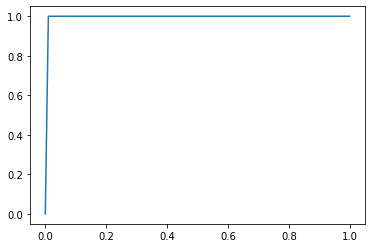

In [867]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure()
#ax = fig.gca(projection='3d')
plt.plot(_x[0], p0)
#fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.show()

In [868]:
initial_condition = Dirichlet({'x': x,'t':t0}, {'p': p0.reshape(-1)}, device=device, name="initial")

In [869]:
p0.shape

(100,)

In [870]:
pde.add_boco(initial_condition)
#p0=np.ones(len(y))
#p1=np.zeros(len(y))

In [871]:
pwf = PBC0({'x': np.array([0]),'t':t}, name='pwf', device=device)
#left = Dirichlet({'x': x, 'y': y}, {'p': p0.reshape(-1)}, device=device, name="left")

In [872]:

pde.add_boco(pwf)

In [873]:
#right = PBC0({'x': np.array([1]), 'y': y, 't':t}, name='right', device=device)
#right = Dirichlet({'x': x[-1], 'y': y}, {'p': p1.reshape(-1)}, device=device, name="right")
right =  NeumannX({'x': x[-1],'t':t}, name='right', device=device)

In [874]:
pde.add_boco(right)

In [875]:
#from nangs import MLP

BATCH_SIZE = 128
LR = 1e-2
EPOCHS = 2
NUM_LAYERS = 3
NUM_HIDDEN = 50

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

In [876]:
mlp

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Sequential(
      (0): Dropout(p=0.0, inplace=False)
      (1): GELU()
      (2): Linear(in_features=50, out_features=50, bias=True)
    )
    (2): Sequential(
      (0): Dropout(p=0.0, inplace=False)
      (1): GELU()
      (2): Linear(in_features=50, out_features=50, bias=True)
    )
    (3): Sequential(
      (0): Dropout(p=0.0, inplace=False)
      (1): GELU()
      (2): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)

In [877]:
EPOCHS = 300
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

In [878]:
pde.compile(mlp, optimizer, scheduler)

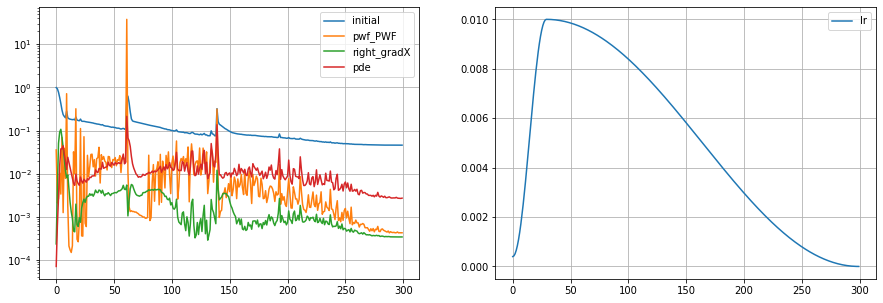

CPU times: user 7min 38s, sys: 9.73 s, total: 7min 48s
Wall time: 7min 42s


In [879]:

%time hist = pde.solve(EPOCHS, BATCH_SIZE)

In [726]:
t = 0.0
x = np.linspace(0,1,100)
#y = np.linspace(0,1,100)

_x, _t = np.meshgrid(x, t)
eval_mesh = Mesh({'x': x,  't':t}, device=device)
p = pde.eval(eval_mesh)
p = p.cpu().numpy()
#p5 = p.reshape((_y.shape[0],_x.shape[1]))

In [727]:
p,grad,loss=pde.eval_with_grad(eval_mesh)

In [885]:
ppp=[]
loss = []
x = np.linspace(0.0,1,100)
for t in [0.01,0.015,0.02,0.1,1,2]:#np.linspace(0.5,1,2):
  #_x,_t = np.meshgrid(x,t)
  eval_mesh = Mesh({'x': x,  't':t}, device=device)
  pp,g,l = pde.eval_with_grad(eval_mesh)
  loss.append(l)
  #pp = pp.cpu().numpy()
  ppp.append(pp)

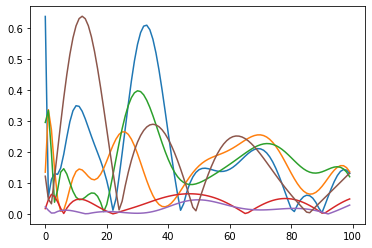

In [886]:
for l in loss:
  plt.plot(np.abs(l))

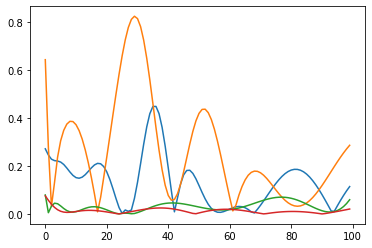

In [768]:
for l in loss:
  plt.plot(np.abs(l))

In [44]:
from sympy import Sum, factorial, oo, IndexedBase, Function, sin,exp
from sympy.abc import n

In [45]:
def diff_sol(x,t,alpha=0.1):
    sol= Sum(4/((2*n + 1)*np.pi)*sin((2*n+1)*np.pi/2*x)*exp(-((2*n + 1)*np.pi/2)**2*t*alpha),(n,0,50))
    
    return sol #,sol_n

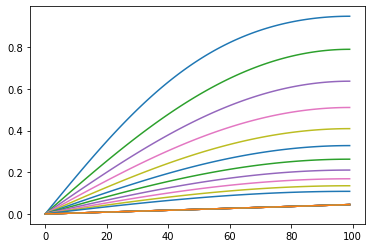

In [384]:
xxx=np.linspace(0,1,100)
for t in np.linspace(0.1,1,11):
    d=[]
    for xx in xxx:
        d.append(diff_sol(xx,t,alpha=1).doit())
    plt.plot(d)
    eval_mesh = Mesh({'x': x,  't':t}, device=device)
    pp = pde.eval(eval_mesh)
    pp = pp.cpu().numpy()
    plt.plot(p)

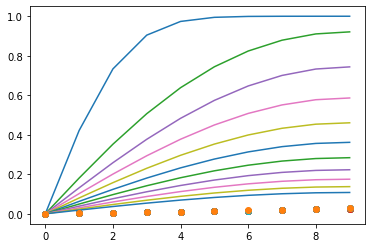

In [149]:
xxx=np.linspace(0,1,10)
x = np.linspace(0,1,10)
for t in np.linspace(0.02,1,11):
    d=[]
    for xx in xxx:
        d.append(diff_sol(xx,t,alpha=1).doit())
    plt.plot(d)
    eval_mesh = Mesh({'x': x,  't':t}, device=device)
    pp = pde.eval(eval_mesh)
    pp = pp.cpu().numpy()
    plt.plot(pp,marker='o',linestyle='None')

In [356]:

out=pde.eval_with_grad(eval_mesh)

In [372]:
out_np=out[1].detach().cpu().numpy()

In [374]:
out_np.shape

(100, 2)

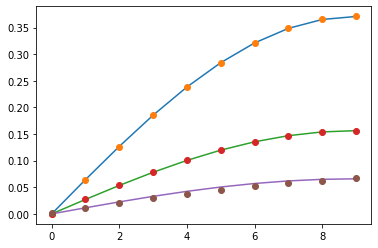

In [895]:
xxx=np.linspace(0,1,10)
x = np.linspace(0,1,10)
for t in np.linspace(0.5,1.2,3):
    d=[]
    for xx in xxx:
        d.append(diff_sol(xx,t,alpha=1).doit())
    plt.plot(d)
    eval_mesh = Mesh({'x': x,  't':t}, device=device)
    pp = pde.eval(eval_mesh)
    pp = pp.cpu().numpy()
    plt.plot(pp,marker='o',linestyle='None')

In [700]:
class PDE():

    def __init__(self, inputs, outputs):

        # check lists of unique strings, non-repeated
        if isinstance(inputs, str):
            inputs = tuple(inputs)
        if isinstance(outputs, str):
            outputs = tuple(outputs)

        checkIsListOfStr(inputs)
        checkIsListOfStr(outputs)
        checkUnique(inputs)
        checkUnique(outputs)
        checkNoRepeated(inputs, outputs)

        self.inputs = inputs
        self.outputs = outputs
        self.mesh = None
        self.bocos = []

    def set_mesh(self, mesh):
        assert mesh.vars == self.inputs, "your data does not match the PDE inputs"
        self.mesh = mesh

    def add_boco(self, boco):
        assert boco.name not in [
            boco.name for boco in self.bocos], f'Boco {boco.name} already exists, use another name'
        boco.validate(self.inputs, self.outputs)
        self.bocos.append(boco)

    def compile(self, model, optimizer, scheduler=None, criterion=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion if criterion else torch.nn.MSELoss()
        self.scheduler = scheduler

    def computePDELoss(self, vars, grads):
        print("This function need to be overloaded !!!")

    def solve(self, epochs=50, batch_size=None, shuffle=True, graph=True):
        dataloaders = self.set_dataloaders(batch_size, shuffle)
        if graph:
            self.graph_fig, (self.graph_ax1, self.graph_ax2) = plt.subplots(
                1, 2, figsize=(15, 5))
            self.graph_out = display(self.graph_fig, display_id=True)
        # solve PDE
        history = History()
        mb = master_bar(range(1, epochs+1))
        for epoch in mb:
            history.add({'lr': get_lr(self.optimizer)})
            # iterate over the internal points in batches
            for batch in progress_bar(dataloaders['inner'], parent=mb):
                X = batch
                self.optimizer.zero_grad()
                # optimize for boundary points
                for boco in self.bocos:
                    for batch in dataloaders['bocos'][boco.name]:
                        loss = boco.computeLoss(
                            batch, self.model, self.criterion)
                        for name, l in loss.items():
                            l.backward()
                            history.add_step({name: l.item()})
                # optimize for internal points
                X.requires_grad = True
                p = self.model(X)
                loss = self.computePDELoss(X, p)
                assert isinstance(
                    loss, dict), "you should return a dict with the name of the equation and the corresponding loss"
                for name, l in loss.items():
                    l = self.criterion(l, torch.zeros(
                        l.shape).to(self.mesh.device))
                    l.backward(retain_graph=True)
                    history.add_step({name: l.item()})
                self.optimizer.step()
                mb.child.comment = str(history.average())
            history.step()
            mb.main_bar.comment = str(history)
            if graph:
                self.plot_history(history)
            # mb.write(f"Epoch {epoch}/{epochs} {history}")
            if self.scheduler:
                self.scheduler.step()
        if graph:
            plt.close()
        return history.history

    def plot_history(self, history):
        self.graph_ax1.clear()
        self.graph_ax2.clear()
        for name, metric in history.history.items():
            if name != 'lr':
                self.graph_ax1.plot(metric, label=name)
            else:
                self.graph_ax2.plot(metric, label=name)
        self.graph_ax1.legend(loc='upper right')
        self.graph_ax2.legend(loc='upper right')
        self.graph_ax1.grid(True)
        self.graph_ax2.grid(True)
        self.graph_ax1.set_yscale("log")
        self.graph_out.update(self.graph_fig)

    def set_dataloaders(self, batch_size, shuffle):
        dataloaders = {
            'inner': self.mesh.build_dataloader(batch_size, shuffle),
            'bocos': {}
        }
        for boco in self.bocos:
            dataloaders['bocos'][boco.name] = boco.build_dataloader(
                batch_size, shuffle)
        return dataloaders

    def computeGrads(self, outputs, inputs):
        grads, = torch.autograd.grad(outputs, inputs,
                                     grad_outputs=outputs.data.new(
                                         outputs.shape).fill_(1),
                                     create_graph=True, only_inputs=True)
        return grads

    def eval(self, mesh, batch_size=None):
        dataloader = mesh.build_dataloader(batch_size, shuffle=False)
        outputs = torch.tensor([]).to(mesh.device)
        self.model.eval()
        with torch.no_grad():
            for batch in dataloader:
                outputs = torch.cat([outputs, self.model(batch)])
        return outputs

    def eval_with_grad(self, mesh, batch_size=None):
        dataloader = mesh.build_dataloader(batch_size, shuffle=False)
        outputs = torch.tensor([]).to(mesh.device)
        self.model.eval()
        #with torch.no_grad():
        for batch in dataloader:
            batch.requires_grad = True
            outputs = self.model(batch)
        #for batch in dataloader:    
            
            #outputs = self.model(batch)
            p=outputs
            X=batch
            X.requires_grad = True
            grad , = torch.autograd.grad(p, X, 
                    grad_outputs=p.data.new(p.shape).fill_(1),
                    create_graph=True, only_inputs=True)
            loss = self.computePDELoss(X,p)
        return outputs,grad,loss['pde'].detach().cpu().numpy()

    def get_loss(self, mesh):
      batch_size = None
      dataloader = mesh.build_dataloader(batch_size, shuffle=False)
      self.model.eval()
      for batch in dataloader:
          batch.requires_grad = True
          outputs = self.model(batch)
          loss = self.computePDELoss(batch,outputs)
      return loss

In [12]:
def checkIsListOfStr(l):
    "Make sure that l is a list containing only strings"
    if isinstance(l, tuple):
        for i in l:
            if not isinstance(i, str):
                raise Exception(str(i) + ' must be a string')


def checkUnique(l):
    "Make sure that l does not contain repeated elements"
    for i, item1 in enumerate(l):
        for j, item2 in enumerate(l):
            if i != j and item1 == item2:
                raise Exception('Repeated item ' + str(item1))


def checkNoRepeated(l1, l2):
    "Make sure there are no repeated elements in both lists"
    for i in l1:
        if i in l2:
            raise Exception('Repeated item ' + str(i))

In [38]:
import numpy as np


class History():
    def __init__(self, precision=5):
        self.history = {}
        self.current = {}
        self.precision = precision

    def add(self, d):
        for name, metric in d.items():
            if not name in self.history:
                self.history[name] = []
            self.history[name].append(metric)

    def add_step(self, d):
        for name, metric in d.items():
            if name not in self.current:
                self.current[name] = []
            self.current[name].append(metric)

    def average(self):
        return {name: round(np.mean(self.current[name]), self.precision) for name in self.current}

    def step(self):
        for name in self.current:
            self.add({name: np.mean(self.current[name])})
        self.current = {}

    def __str__(self):
        s = ''
        for name, value in self.history.items():
            s += f' | {name} {round(value[-1], self.precision)}'
        return s

In [40]:
from fastprogress import master_bar, progress_bar

In [42]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']